In [97]:
import salem
import cleo
import pyproj
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage.measurements import label
from eod import msg
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pickle as pkl
%matplotlib inline

In [86]:
ind_dic={ '845' : [0,300, 0, 400, 30, 400, 0, -1], }
    
   
    
# make a salem grid
proj = pyproj.Proj('+proj=merc +lat_0=0. +lon_0=0.')
    
sav_mcs={'845' : {'lat' : [], 'lon' : [], 'dmin' : [], 'date' : [], 'trmm' : [], 'msg' : [] }}
 
HOD=range(24)   # hours of day
YRANGE=range(2004,2014)

tpath= "/users/global/cornkle/data/OBS/TRMM/trmm_swaths_WA/"
tf=msg.extract_TRMMfile(tpath, hod=HOD, yrange=YRANGE, mtresh=1)    
   
tnb=np.array(range(len(tf['fpath'])))
maxs=[]
for tp in tnb:
        dmsg, dtrmm=msg.quickreadTrmmMSG(tf, nb=tp)
        td=dtrmm['pcp'].mean().max()
        maxs.append(td)
sort_max, sort_nbs = zip(*sorted(zip(maxs, tnb), reverse=True))

In [8]:
for nb in ind_dic.keys():
    nb=nb

In [88]:
nb='845'
nbn=int(nb)
mi=tf['tmins'][nbn]
date=tf['date'].get_str([nbn])
dmsg, dtrmm=msg.quickreadTrmmMSG(tf, nb=nbn)       

In [115]:
md=dmsg['t']
lat=dmsg['lats']
lon=dmsg['lons']
tlat=dtrmm['lats']
tlon=dtrmm['lons']
td=dtrmm['pcp']        

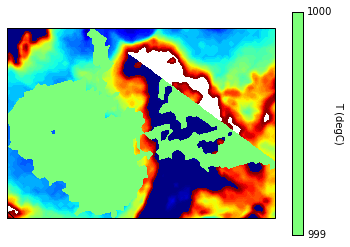

In [165]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(tlon, tlat, td, levels=np.arange(0,100, 1), transform=ccrs.PlateCarree())
plt.contourf(lon, lat, md,  levels=np.arange(-80,-30,1), transform=ccrs.PlateCarree())
plt.contourf(tlon, tlat, l_array, levels=np.arange(999,1001, 1), transform=ccrs.PlateCarree())
#
#plt.contourf(lon, lat, tr, levels=np.arange(5,50,0.5), transform=ccrs.PlateCarree()) # evels=np.arange(5,70, 0.5)

cbar=plt.colorbar()
cbar.set_label('T (degC)', rotation=270, labelpad=+11)

In [155]:
l_array, num = label(td)      

In [166]:
np.histogram(l_array.flatten(), nbins)

(array([22207,    94,     0,     0,     0,     0,     0,     0,     0,  1611]),
 array([    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,
          800.,   900.,  1000.]))

In [163]:
l_array[np.where(l_array == 82)]=1000

In [145]:
np.bincount(l_array.flatten())

array([20102,     1,     2,    26,     5,     4,     2,    10,     2,
           1,     1,     1,     1,     1,     1,     1,    73,     1,
           3,     4,     1,     1,     1,    65,     1,     1,     1,
           1,     1,     1,     1,     2,     1,     2,     1,     2,
          15,     1,     1,     1,     2,     1,     1,     1,     1,
          18,     4,     1,     1,     1,     2,     1,     2,     2,
           1,     1,     2,     1,     5,     2,     3,     1,     1,
           1,     4,     1,     2,     5,    11,     1,     1,     1,
           3,    25,    12,    14,     1,    37,     1,     2,     3,
          51,  1611,     4,     1,     7,     2,    15,     1,     1,
           1,     1,     1,     1,     1,     1,    47,  1546,     1,
           2,     1,     1,     1,     2,     1,     6,     3,     2,
           1,    12,     1,     7,     3,     1,    16,     7,    10,
           1,     3,     2,     5,     1,     1,     1,     1,     2,
           1,     1]

In [277]:
# Transform lon, lats to the mercator projection
mx, my = pyproj.transform(salem.wgs84, proj, mlon, mlat)
tx, ty = pyproj.transform(salem.wgs84, proj, tlon, tlat)
        
ax=mx.flatten().tolist()
ax.extend(tx.flatten().tolist())
ay=my.flatten().tolist()
ay.extend(ty.flatten().tolist())
        
# take the min and max
xmax, xmin = max(ax), min(ax)
ymax, ymin = max(ay), min(ay)

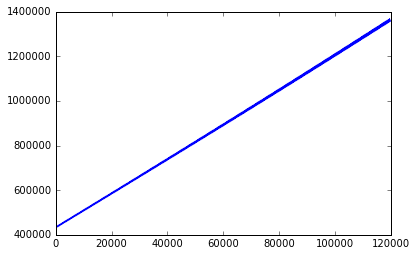

In [44]:
plt.plot(my.flatten())

In [37]:
#Count the number of pixels
dx = 5000
nx, r = divmod(xmax - xmin, dx)
ny, r = divmod(ymax - ymin, dx) 

409413.28242579196

In [45]:
# Here one could add + 1 to be sure that the last pixel is always included
proj = pyproj.Proj('+proj=merc +lat_0=0. +lon_0=0.')
grid = salem.Grid(nxny=(nx, ny), dxdy=(dx, dx), ll_corner=(xmin, ymin), proj=proj)        
xi, yi = grid.ij_coordinates
lon, lat = grid.ll_coordinates

In [81]:
min(lon.flatten())

-18.299999999999997

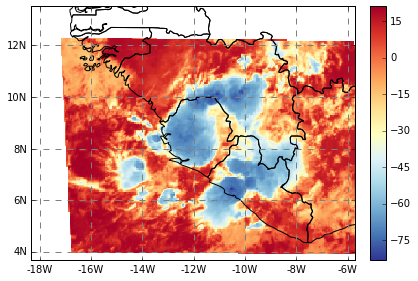

In [65]:
cm = cleo.Map(grid)
cm.set_cmap(plt.cm.RdYlBu_r)
cm.set_nlevels(256)
cm.set_data(outm)
cm.visualize()

In [54]:
xm, ym = grid.transform(mlon.flatten(), mlat.flatten(), crs=salem.wgs84)
xt, yt = grid.transform(tlon.flatten(), tlat.flatten(), crs=salem.wgs84)
        
# Convert for griddata input 
mpoints = np.array((ym, xm)).T
tpoints = np.array((yt, xt)).T
inter = np.array((np.ravel(yi), np.ravel(xi))).T
        
# Interpolate using delaunay triangularization 
outm = griddata(mpoints, md[dy1:dy2, dx1:dx2].flatten(), inter, method='linear')
outm = outm.reshape((grid.ny, grid.nx))
        
# Interpolate using delaunay triangularization 
outt = griddata(tpoints, td[tdy1:tdy2, tdx1:tdx2].flatten(), inter, method='linear')
outt = outt.reshape((grid.ny, grid.nx))
        
        

In [109]:
outt.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [86]:
sav_mcs[nb]['lat']=lat
sav_mcs[nb]['lon']=lon
sav_mcs[nb]['dmin']=mi 
sav_mcs[nb]['date']=date
sav_mcs[nb]['trmm']=outt
sav_mcs[nb]['msg']=outm

In [154]:
date[0]

'20110925 04:30:00'

In [88]:
mc=sav_mcs['845']

In [89]:
mc.keys()

dict_keys(['trmm', 'msg', 'date', 'lat', 'lon', 'dmin'])

In [90]:
mc['dmin']

27

In [91]:
savefile = '/users/global/cornkle/mt_wavelet_test.p'
pkl.dump(sav_mcs, open(savefile, 'wb'))

In [63]:
import xarray as xray
dic = xray.open_dataset('/users/global/cornkle/wtest/730_mt_wavelet_test.nc')

In [64]:
tr=dic.trmm.values
tr

array([[ -1.00000000e-05,  -1.00000000e-05,  -1.00000000e-05, ...,
          0.00000000e+00,   4.83362714e-01,   5.59895045e+00],
       [ -1.00000000e-05,  -1.00000000e-05,  -1.00000000e-05, ...,
          2.10455627e+00,   9.15224603e-01,   3.64211701e-01],
       [ -1.00000000e-05,  -1.00000000e-05,  -1.00000000e-05, ...,
          3.35974902e+00,   2.78352198e+00,   1.83421879e+00],
       ..., 
       [  1.49607384e+00,   2.43890907e-01,   1.93863768e+00, ...,
         -1.00000000e-05,  -1.00000000e-05,  -1.00000000e-05],
       [  2.57908098e-01,   3.41382286e-01,   2.38226156e+00, ...,
         -1.00000000e-05,  -1.00000000e-05,  -1.00000000e-05],
       [  3.53403985e-02,   8.30606694e-01,   1.98163671e+01, ...,
         -1.00000000e-05,  -1.00000000e-05,  -1.00000000e-05]])

In [65]:
msg=dic.msg.values
msg

array([[ 30.        , -20.88147158, -24.27095492, ..., -13.20901387,
        -17.77101219, -11.19227286],
       [ 30.        , -27.84691978, -24.40274054, ..., -11.0955307 ,
        -14.61600456, -12.37125799],
       [ 30.        , -26.71684056, -22.596333  , ..., -11.        ,
        -10.63408567,  -6.1555139 ],
       ..., 
       [-74.56106737, -76.95393157, -77.63481869, ..., -45.87274129,
        -45.90556219, -44.67412387],
       [-79.38209333, -80.32396792, -80.44412585, ..., -49.41456633,
        -45.15045519, -42.10221889],
       [-79.03090569, -80.05597385, -81.53258132, ..., -48.34299846,
        -42.57148596, -37.92093867]])

In [66]:
lon=dic.lon.values
lat=dic.lat.values
lat

array([[  5.73963942,   5.73963942,   5.73963942, ...,   5.73963942,
          5.73963942,   5.73963942],
       [  5.78462638,   5.78462638,   5.78462638, ...,   5.78462638,
          5.78462638,   5.78462638],
       [  5.82960971,   5.82960971,   5.82960971, ...,   5.82960971,
          5.82960971,   5.82960971],
       ..., 
       [ 13.093432  ,  13.093432  ,  13.093432  , ...,  13.093432  ,
         13.093432  ,  13.093432  ],
       [ 13.13745576,  13.13745576,  13.13745576, ...,  13.13745576,
         13.13745576,  13.13745576],
       [ 13.18147153,  13.18147153,  13.18147153, ...,  13.18147153,
         13.18147153,  13.18147153]])

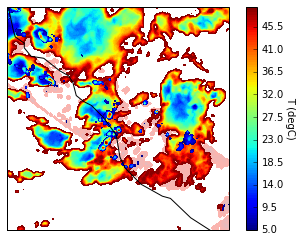

In [81]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(lon, lat, tr, levels=np.arange(0,100, 0.5), transform=ccrs.PlateCarree(), cmap='Pastel1')
plt.contourf(lon, lat, msg,  levels=np.arange(-80,-30,1), transform=ccrs.PlateCarree())
plt.contourf(lon, lat, tr, levels=np.arange(5,50,0.5), transform=ccrs.PlateCarree()) # evels=np.arange(5,70, 0.5)

cbar=plt.colorbar()
cbar.set_label('T (degC)', rotation=270, labelpad=+11)

In [82]:
trmm=item['trmm']
msg=item['msg']

NameError: name 'item' is not defined

In [121]:
trmm.shape

(220, 281)

In [122]:
msg.shape

(220, 281)

In [167]:
60*3/3

60.0

In [168]:
60.*3./3.

60.0

In [169]:
60./3.*3.

60.0